In [ ]:
%load_ext autoreload
%autoreload 2 
#default_exp model

In [ ]:
#exporti
from fastai.tabular.all import * 

In [ ]:
! pip install -e ../../libraries/fastai ../../libraries/fastcore 

# Creating the model 

The TabNet model consists of the following parts (which we'll implement):
1. Attentive Transformer - aka, the `MaskBlock` which is in charge of creating the mask given the previous step's output
1. Feature Transformer - which given the masked features is in charge of processing them to a better representation. Internally it's made out of multiple `FeatureTransformerBlock`s. 

These two are the building blocks for the `TabNetStep` which is represents the steps in a `TabNet`. 

Todo: 
1. sqrt(0.5) 
1. save masks for interpretation

### Mask Block

The mask block creates a mask from the vector that it gets from the previous step (of size, `ni`), 
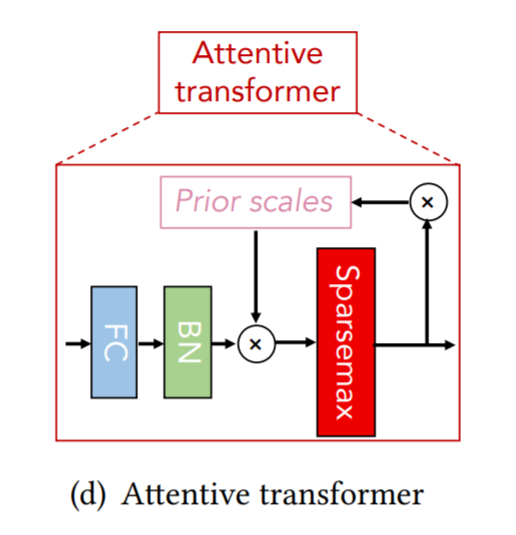

In [ ]:
#exporti 

class MaskBlock(Module):
    
    def __init__(self, nf, ni, max_func=nn.Softmax(dim=1), gamma=1):
        store_attr('gamma,max_func')
        
        self.fc = LinBnDrop(ni, nf, lin_first=True)
        self.prior = torch.ones(nf, dtype=torch.float)
        
    def forward(self, prev):
        mask = self._calc_mask(prev)
        self.prior = self._calc_prior_scales(mask)
        return mask
        
    def _calc_mask(self, prev):
        return self.max_func(self.fc(prev) * self.prior)
    
    def _calc_prior_scales(self, mask):
        return (self.gamma - mask)*self.prior

In [ ]:
N = 3
nf = 32
ni = 8 
mb = MaskBlock(nf, ni)
a = torch.randn((N,ni), dtype=torch.float)
test_close(mb(a).sum(dim=1),1)

### Feature Transformer

The `FeatureTransformerBlock` uses a GLU in the end which halves the size of the input. For us to get the same size output we need the linear layers to double the output size.

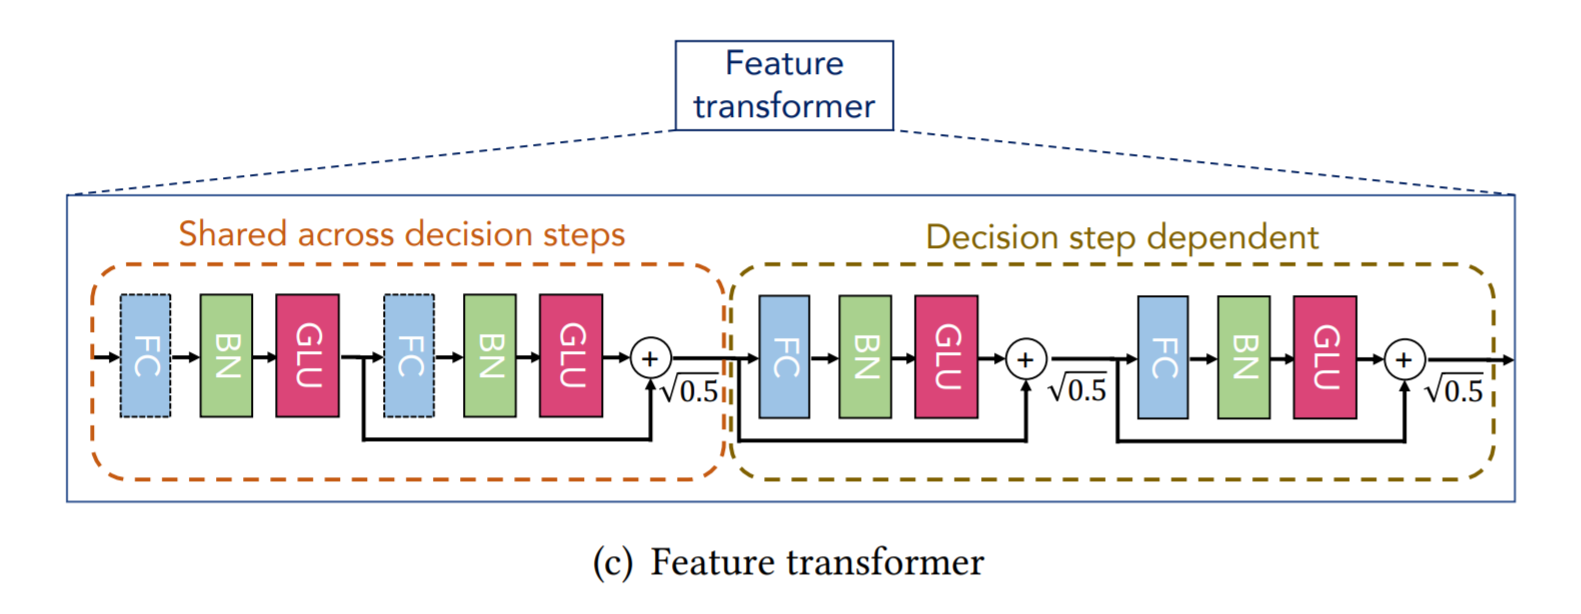

In [ ]:
#exporti 

class FeatureTransformerBlock(Module):
    
    def __init__(self, nf, nt, add_input=False):
        store_attr('nf,nt,add_input')
        
        self.b1 = self._inner_block(self.nf, 2*self.nt)
        self.b2 = self._inner_block(self.nt, 2*self.nt)
        

    def forward(self, inp):
        x1 = self.b1(inp)
        if self.add_input: x1 += inp
        x2 = self.b2(x1)
        return x1 + x2
        
    
    def _inner_block(self, n_in, n_out):
        return nn.Sequential(LinBnDrop(n_in, n_out, lin_first=True), nn.GLU())

In [ ]:
nt = nf
a = torch.randn((N,nf), dtype=torch.float)
ft = FeatureTransformerBlock(nf, nt)
test_eq(ft(a).shape, (N, nt))

In [ ]:
#exporti 

class FeatureTransformer(nn.Sequential):
    
    def __init__(self, nf, nt, n_blocks=2):
        FeatureTransformer.shared_block = self._create_block(nf, nt)
        layers = [
            FeatureTransformer.shared_block, 
            *[self._create_block(nt, nt, add_input=True) for i in range(n_blocks-1)]
        ]

        super().__init__(*layers)
        
        
    def _create_block(self, nf, nt, **kwargs):
        return FeatureTransformerBlock(nf, nt, **kwargs)

In [ ]:
a = torch.randn((N,nf), dtype=torch.float)
trans = FeatureTransformer(nf, nt, 2)
test_eq(trans(a).shape, (N, nt))

In [ ]:
#exporti 

def _split(x):
    N = x.shape[-1]//2
    return x[:,:N], x[:,N:]
Split = Lambda(_split)

In [ ]:

res = Split(torch.randn((3,4)))
test_eq(len(res), 2)
test_eq(res[0].shape, (3,2))

### TabNet

Notice that the `MaskBlock`'s input from the previous part is $\frac{1}{2}$ of the `n_transformed_features`. 

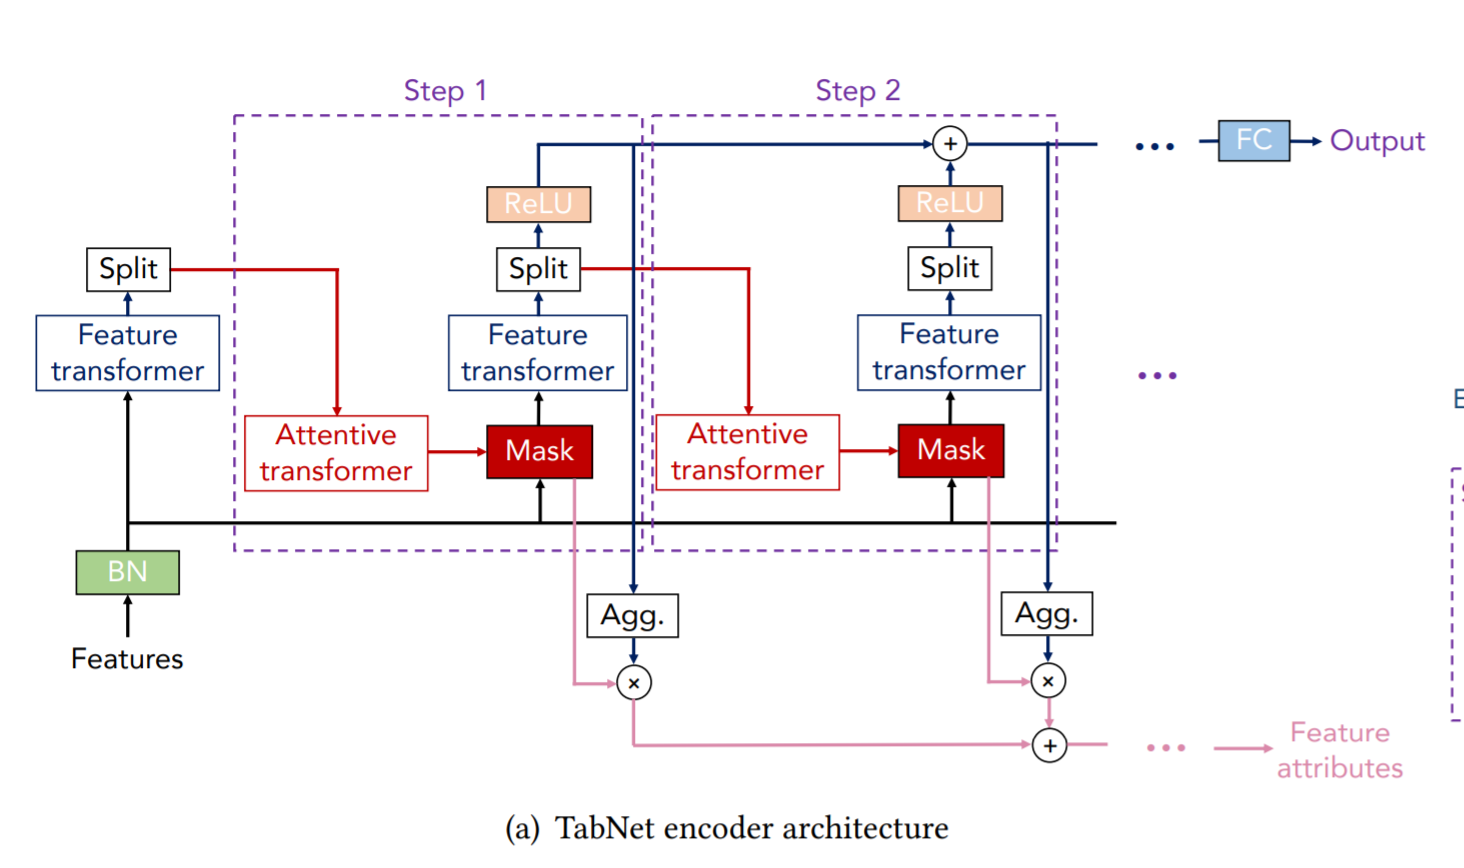

In [ ]:
#exporti 

class TabNetStep(Module):
    
    @delegates(FeatureTransformer)
    def __init__(self, nf, nt, activ=nn.ReLU(), **kwargs):
        store_attr('activ')

        self.mask = MaskBlock(nf, nt//2)
        self.feat_trans = FeatureTransformer(nf, nt, **kwargs)
        
        
    def forward(self, features, prev):
        
        masked = self.mask(prev) * features 
        transformed = self.feat_trans(masked)
        output, next_input = Split(transformed)
        output = self.activ(output)
        return output, next_input
        


In [ ]:
a = torch.randn((N, nf))
tab_step = TabNetStep(nt, nt)
prev = torch.randn((N, nt//2))
res = tab_step(features=a, prev=prev)
test_eq(len(res), 2)
test_eq(torch.cat(res, dim=1).shape, (N, nt))

In [ ]:
#export

class TabNet(Module):
    
    @delegates(TabNetStep)
    def __init__(self, nf, nt, n_steps=2, **kwargs):        
        store_attr('nf,nt,n_steps')
        self.init = nn.Sequential(
            BatchNorm(nf, ndim=1),
            FeatureTransformer(nf, nt), 
            Split,
        )
        
        self.steps = nn.ModuleList(
            [TabNetStep(nf, nt, **kwargs) for i in range(n_steps)]
        )

        
    
    def forward(self, x_cat, x_cont):
        outputs = 0

        output, next_input = self.init(x_cont)     
        
        for step in self.steps:        
            output, next_input = step(x_cont, next_input)
            outputs = torch.add(outputs, output)
    
        return outputs

* result should be the same size as the input batch
* the output dim size should be half of `nt`

In [ ]:
a = torch.randn((N, nf))
tabnet = TabNet(nf, nt)
test_eq(tabnet(a,a).shape, (N, nt//2))

# Export

In [ ]:
from nbdev.export import notebook2script
notebook2script()